# Build and Evaluate a Linear Risk model

Welcome to the first assignment in Course 2!


## Outline

- [1. Import Packages](#1)
- [2. Load Data](#2)
- [3. Explore the Dataset](#3)
- [4. Mean-Normalize the Data](#4)
    - [Exercise 1](#Ex-1)
- [5. Build the Model](#Ex-2)
    - [Exercise 2](#Ex-2)
- [6. Evaluate the Model Using the C-Index](#6)
    - [Exercise 3](#Ex-3)
- [7. Evaluate the Model on the Test Set](#7)
- [8. Improve the Model](#8)
    - [Exercise 4](#Ex-4)
- [9. Evalute the Improved Model](#9)

## Overview of the Assignment

In this assignment, you'll build a risk score model for retinopathy in diabetes patients using logistic regression.

As we develop the model, we will learn about the following topics:

- Data preprocessing
  - Log transformations
  - Standardization
- Basic Risk Models
  - Logistic Regression
  - C-index
  - Interactions Terms
  
### Cardiovasular studies
Retinopathy is an eye condition that causes changes to the blood vessels in the part of the eye called the retina.
This often leads to vision changes or blindness.
Diabetic patients are known to be at high risk for retinopathy. 
    
### Logistic Regression    
Logistic regression is an appropriate analysis to use for predicting the probability of a binary outcome. In our case, this would be the probability of having or not having diabetic retinopathy.
Logistic Regression is one of the most commonly used algorithms for binary classification. It is used to find the best fitting model to describe the relationship between a set of features (also referred to as input, independent, predictor, or explanatory variables) and a binary outcome label (also referred to as an output, dependent, or response variable). Logistic regression has the property that the output prediction is always in the range $[0,1]$. Sometimes this output is used to represent a probability from 0%-100%, but for straight binary classification, the output is converted to either $0$ or $1$ depending on whether it is below or above a certain threshold, usually $0.5$.

It may be  confusing that the term regression appears in the name even though logistic regression is actually a classification algorithm, but that's just a name it was given for historical reasons.

<a name='1'></a>
## 1.  Import Packages

We'll first import all the packages that we need for this assignment. 

- `numpy` is the fundamental package for scientific computing in python.
- `pandas` is what we'll use to manipulate our data.
- `matplotlib` is a plotting library.

# 2. Dataset :

- https://www.kaggle.com/andrewmvd/heart-failure-clinical-data

### Data Description
Demographic:
* Sex: male or female("M" or "F")
* Age: Age of the patient;(Continuous - Although the recorded ages have been truncated to whole numbers, the concept of age is continuous)
Behavioral
* is_smoking: whether or not the patient is a current smoker ("YES" or "NO")
* Cigs Per Day: the number of cigarettes that the person smoked on average in one day.(can be considered continuous as one can have any number of cigarettes, even half a cigarette.)
Medical( history)
* BP Meds: whether or not the patient was on blood pressure medication (Nominal)
* Prevalent Stroke: whether or not the patient had previously had a stroke (Nominal)
* Prevalent Hyp: whether or not the patient was hypertensive (Nominal)
* Diabetes: whether or not the patient had diabetes (Nominal)
Medical(current)
* Tot Chol: total cholesterol level (Continuous)
* Sys BP: systolic blood pressure (Continuous)
* Dia BP: diastolic blood pressure (Continuous)
* BMI: Body Mass Index (Continuous)
* Heart Rate: heart rate (Continuous - In medical research, variables such as heart rate though in fact discrete, yet are considered continuous because of large number of possible values.)
* Glucose: glucose level (Continuous)
Predict variable (desired target)
* 10 year risk of coronary heart disease CHD(binary: “1”, means “Yes”, “0” means “No”)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
## preprocessing pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from utils import *
import seaborn as sns

<a name='2'></a>
## 2. Load Data

First we will load in the dataset that we will use for training and testing our model.

- Run the next cell to load the data that is stored in csv files.
- There is a function `load_data` which randomly generates data, but for consistency, please use the data from the csv files.

In [2]:

df = pd.read_csv('/content/Cardiovascular Study Dataset_train.csv')

In [3]:

df = df.drop(['id', 'education'], axis =1)

In [4]:
df.head(1)

,age,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,64,F,YES,3.0,0.0,0,0,0,221.0,148.0,85.0,NaN,90.0,80.0,1


In [5]:

X = df.drop('TenYearCHD', axis =1)
y_df = df['TenYearCHD']
y = y_df

In [6]:
X.head(1)

,age,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose
0,64,F,YES,3.0,0.0,0,0,0,221.0,148.0,85.0,NaN,90.0,80.0


`X` and `y` are Pandas DataFrames that hold the data for 6,000 diabetic patients. 

<a name='3'></a>
##  3. Explore the Dataset

The features (`X`) include the following fields:
* id                   0
* age                  0
* education           87
* sex                  0
* is_smoking           0
* cigsPerDay          22
* BPMeds              44
* prevalentStroke      0
* prevalentHyp         0
* diabetes             0
* totChol             38
* sysBP                0
* diaBP                0
* BMI                 14
* heartRate            1
* glucose            304
    
    

The target (`y`) is an indicator of whether or not the patient developed retinopathy.

* y = 1 : patient has retinopathy.
* y = 0 : patient does not have retinopathy.

In [7]:

features = ['age','cigsPerDay','totChol'	,'sysBP'	,'diaBP',	'BMI',	'heartRate'	,'glucose']
categorical = ['sex', 'is_smoking','BPMeds', 'prevalentStroke','prevalentHyp','diabetes']

In [8]:
X.head(1)

,age,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose
0,64,F,YES,3.0,0.0,0,0,0,221.0,148.0,85.0,NaN,90.0,80.0


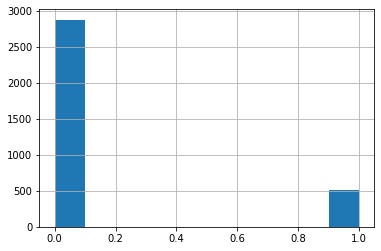

In [9]:
y.hist()

# Dataset spliting 

In [10]:
from sklearn.model_selection import train_test_split

In [12]:
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, train_size=0.75,stratify =y,  random_state=0, shuffle=True)

As we can see, the distributions have a generally bell shaped distribution, but with slight rightward skew.

Many statistical models assume that the data is normally distributed, forming a symmetric Gaussian bell shape (with no skew) more like the example below.

We can transform our data to be closer to a normal distribution by removing the skew. One way to remove the skew is by applying the log function to the data.

Let's plot the log of the feature variables to see that it produces the desired effect.

age


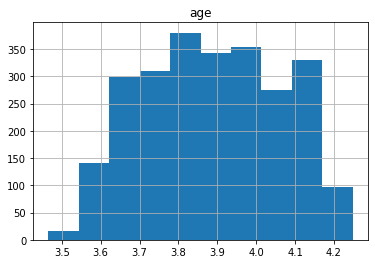

In [13]:
for col in X_train_raw[features]:
    print(col)
    np.log(X_train_raw.loc[:, col],).hist()
    plt.title(col)
    plt.show()
    break
    
    

We can see that the data is more symmetric after taking the log.

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Hints</b></font>
</summary>
<p>
    <ul>
        <li> When working with Pandas DataFrames, you can use the aggregation functions <code>mean</code> and <code>std</code> functions. Note that in order to apply an aggregation function separately for each row or each column, you'll set the axis parameter to either <code>0</code> or <code>1</code>. One produces the aggregation along columns and the other along rows, but it is easy to get them confused. So experiment with each option below to see which one you should use to get an average for each column in the dataframe.
<code>
avg = df.mean(axis=0)
avg = df.mean(axis=1) 
</code>
        </li>
        <br></br>
    <li>Remember to use <b>training</b> data statistics when standardizing both the training and the test data.</li>
    </ul>
</p>
</details> 

#### Transform training and test data 
Use the function that you just implemented to make the data distribution closer to a standard normal distribution.

In [14]:
#X_train, X_test = make_standard_normal(X_train_raw, X_test_raw, features)
X_train = X_train_raw.copy(deep=True)
X_test  = X_test_raw.copy(deep=True)

After transforming the training and test sets, we'll expect the training set to be centered at zero with a standard deviation of $1$.

We will avoid observing the test set during model training in order to avoid biasing the model training process, but let's have a look at the distributions of the transformed training data.

<a name='5'></a>
## 5. Build the Model

Now we are ready to build the risk model by training logistic regression with our data.


<details>    
<summary>
    <font size="3" color="darkgreen"><b>Hints</b></font>
</summary>
<p>
    <ul>
        <li>You can leave all the parameters to their default values when constructing an instance of the <code>sklearn.linear_model.LogisticRegression</code> class. If you get a warning message regarding the <code>solver</code> parameter, however, you may want to specify that particular one explicitly with <code>solver='lbfgs'</code>. 
        </li>
        <br></br>
    </ul>
</p>
</details> 

In [15]:
# UNQ_C2 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def lr_model(X_train, y_train, preprocessor, impute= True,model='GB'):
    
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    # import the LogisticRegression class
    from sklearn.linear_model import LogisticRegression
    from sklearn.ensemble import GradientBoostingClassifier
    
    # create the model object
    if model == 'LR':
      model = LogisticRegression(penalty='l2', max_iter=1000,verbose=1,class_weight ='balanced')
    else:
      model = GradientBoostingClassifier( learning_rate=0.1, n_estimators=300, max_depth=5)#
    if impute:
        X_train = preprocessor.fit_transform(X_train)
        # fit the model to the training data
    model.fit(X_train , y_train)
    
    ### END CODE HERE ###
    #return the fitted model
    
    return model, pd.DataFrame(X_train)

#### Test Your Work

Note: the `predict` method returns the model prediction *after* converting it from a value in the $[0,1]$ range to a $0$ or $1$ depending on whether it is below or above $0.5$.

Now that we've tested our model, we can go ahead and build it. Note that the `lr_model` function also fits  the model to the training data.

In [17]:
def imputer(numeric_cols , categorical_cols):
      numeric_features = numeric_cols
      numeric_transformer = Pipeline(steps=[
                                    ('imputer', SimpleImputer(strategy='mean')),
                                    ('scaler', StandardScaler())])

      categorical_features = categorical_cols
      categorical_transformer =  Pipeline(steps=[
                                        ('imputer', SimpleImputer(strategy='most_frequent')),
                                        ('encod', OneHotEncoder(drop='first'))])

      preprocessor = ColumnTransformer(transformers=[
                                      ('num', numeric_transformer, numeric_features),
                                      ('cat', categorical_transformer, categorical_features)])
      
      #transformer = preprocessor.fit(X)
      #X = transformer.transform(X)
      return preprocessor

In [18]:

preprocessor = imputer(numeric_cols = features, categorical_cols=categorical)
model_X, data = lr_model(X_train, y_train,preprocessor=preprocessor)

In [60]:
data.head(1)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,-0.182808,-0.765156,0.145239,-0.705568,-0.107908,0.777216,-0.761997,-0.180378,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
data.columns = features + categorical


In [20]:
data.head(1)

,age,cigsPerDay,totChol,sysBP,diaBP,BMI,heartRate,glucose,sex,is_smoking,BPMeds,prevalentStroke,prevalentHyp,diabetes
0,-0.413984,-0.763424,-0.976874,-1.023466,-1.254782,-0.885575,-0.669608,-0.7273,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
X_train_new = data.copy(deep=True)

<a name='6'></a>
## 6. Evaluate the Model Using the C-index

Now that we have a model, we need to evaluate it. We'll do this using the c-index. 
* The c-index measures the discriminatory power of a risk score. 
* Intuitively, a higher c-index indicates that the model's prediction is in agreement with the actual outcomes of a pair of patients.
* The formula for the c-index is

$$ \mbox{cindex} = \frac{\mbox{concordant} + 0.5 \times \mbox{ties}}{\mbox{permissible}} $$

* A permissible pair is a pair of patients who have different outcomes.
* A concordant pair is a permissible pair in which the patient with the higher risk score also has the worse outcome.
* A tie is a permissible pair where the patients have the same risk score.


In [22]:
# UNQ_C3 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def cindex(y_true, scores):
    '''

    Input:
    y_true (np.array): a 1-D array of true binary outcomes (values of zero or one)
        0: patient does not get the disease
        1: patient does get the disease
    scores (np.array): a 1-D array of corresponding risk scores output by the model

    Output:
    c_index (float): (concordant pairs + 0.5*ties) / number of permissible pairs
    '''
    n = len(y_true)
    assert len(scores) == n

    concordant = 0
    permissible = 0
    ties = 0
    
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    # use two nested for loops to go through all unique pairs of patients
    for i in range(n):
        for j in range(i+1, n): #choose the range of j so that j>i
            
            # Check if the pair is permissible (the patient outcomes are different)
            if y_true[i] != y_true[j]:
                # Count the pair if it's permissible
                permissible+=1

                # For permissible pairs, check if they are concordant or are ties

                # check for ties in the score
                if y_true[i] != y_true[j] and scores[i] == scores[j]:
                    # count the tie
                    ties +=1
                    # if it's a tie, we don't need to check patient outcomes, continue to the top of the for loop.
                    continue

                # case 1: patient i doesn't get the disease, patient j does
                if y_true[i] == 0 and y_true[j] == 1:
                    # Check if patient i has a lower risk score than patient j
                    if scores[i] < scores[j]:
                        # count the concordant pair
                        concordant +=1
                    # Otherwise if patient i has a higher risk score, it's not a concordant pair.
                    # Already checked for ties earlier

                # case 2: patient i gets the disease, patient j does not
                if y_true[i] == 1 and y_true[j] == 0:
                    # Check if patient i has a higher risk score than patient j
                    if scores[i] > scores[j]:
                        #count the concordant pair
                        concordant +=1
                    # Otherwise if patient i has a lower risk score, it's not a concordant pair.
                    # We already checked for ties earlier

    # calculate the c-index using the count of permissible pairs, concordant pairs, and tied pairs.
    print("No of permissable :" , permissible)
    print("No of concordant :" , concordant)

    c_index = (concordant + 0.5*ties) / permissible 
    ### END CODE HERE ###
    
    return c_index

<a name='7'></a>
## 7. Evaluate the Model on the Test Set

Now, you can evaluate your trained model on the test set.  

To get the predicted probabilities, we use the `predict_proba` method. This method will return the result from the model *before* it is converted to a binary 0 or 1. For each input case, it returns an array of two values which represent the probabilities for both the negative case (patient does not get the disease) and positive case (patient the gets the disease). 

In [23]:
preprocess = imputer(features ,categorical)

In [24]:
X_test = preprocess.fit_transform(X_test_raw)

In [25]:
X_test_new = pd.DataFrame(X_test, columns= data.columns)

In [26]:
X_test_new.head(1)

,age,cigsPerDay,totChol,sysBP,diaBP,BMI,heartRate,glucose,sex,is_smoking,BPMeds,prevalentStroke,prevalentHyp,diabetes
0,0.903106,-0.77466,1.200217,-0.336678,-0.712787,-1.722721,-0.820575,-0.593759,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:

scores = model_X.predict_proba(X_test)[:, 1]
preds  = model_X.predict(X_test)
c_index_X_test = cindex(y_test.values, scores)
print(f"c-index on test set is {c_index_X_test:.4f}")

No of permissable : 92160
No of concordant : 58988
c-index on test set is 0.6401


In [28]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test , preds))

0.8419811320754716


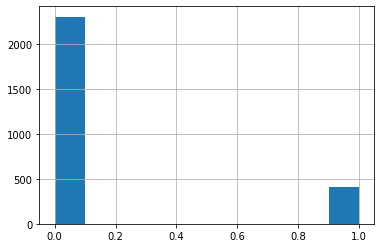

In [38]:
y_train.hist()

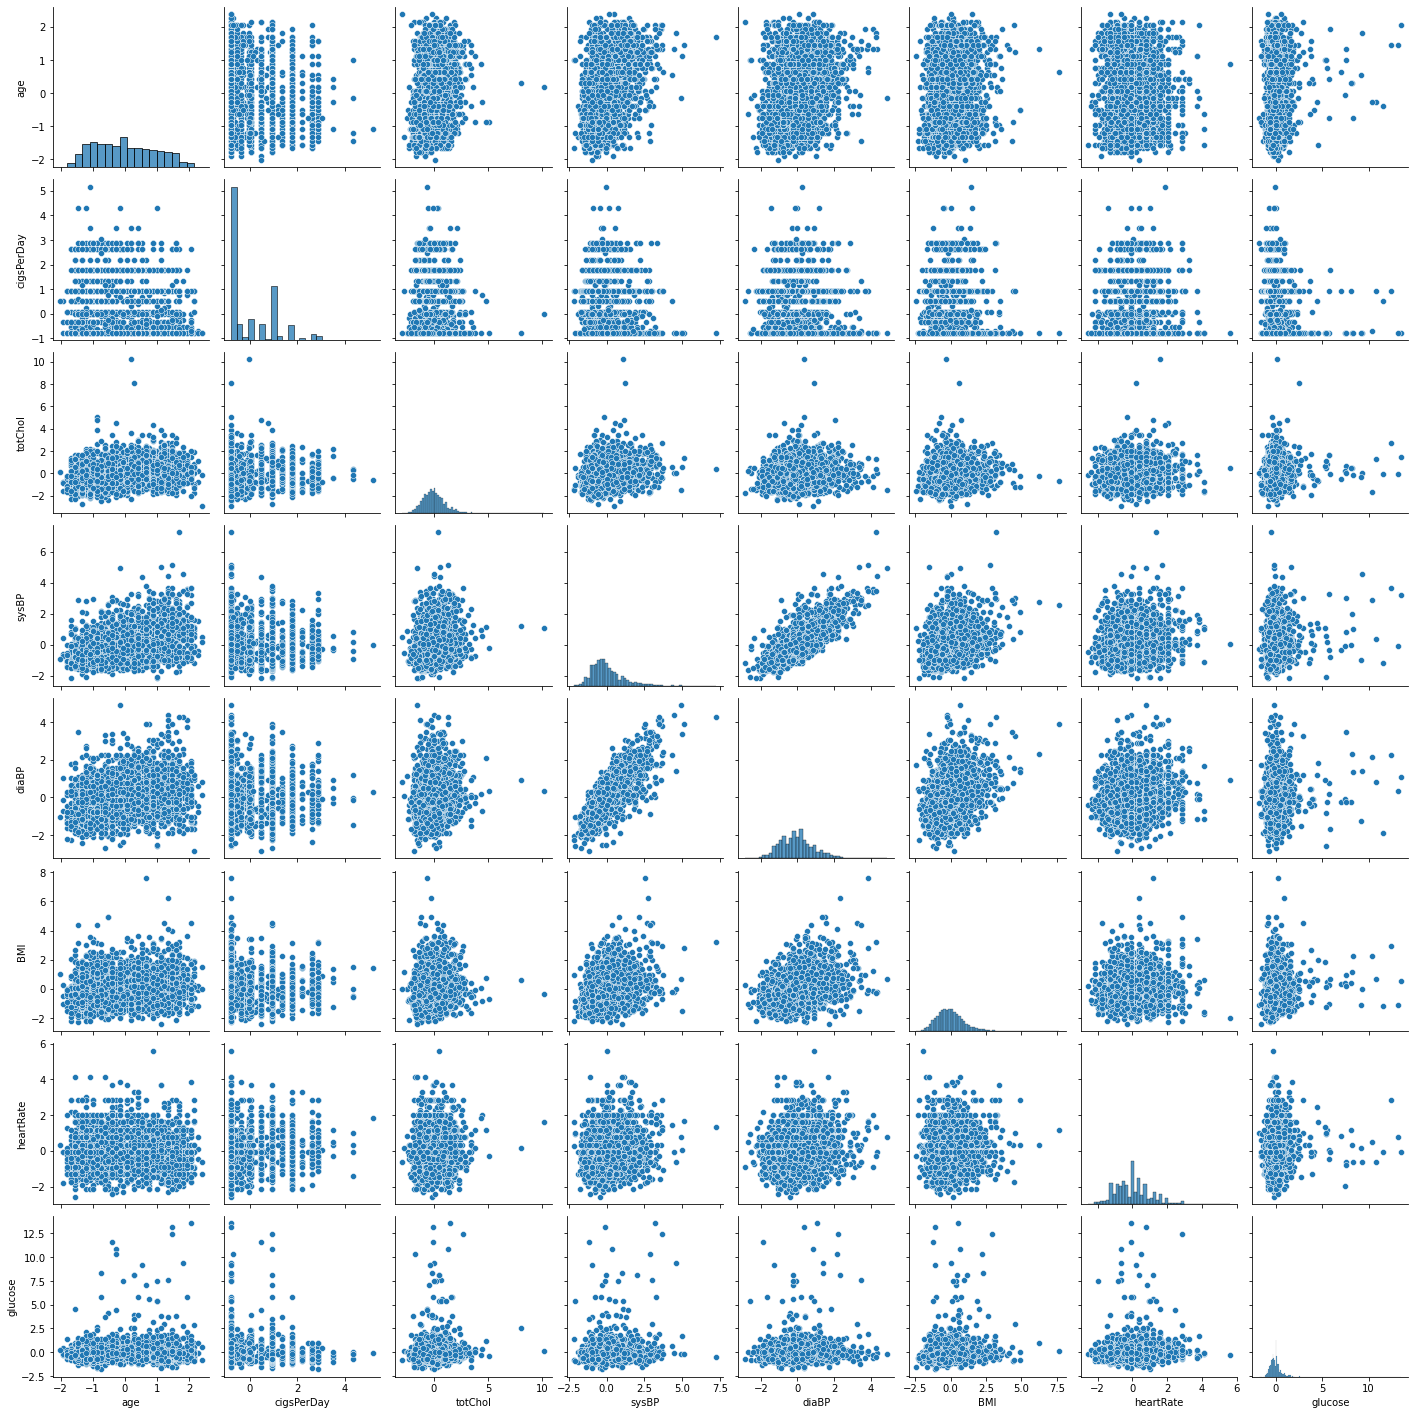

In [46]:
sns.pairplot(data[features])

Let's plot the coefficients to see which variables (patient features) are having the most effect. You can access the model coefficients by using `model.coef_`

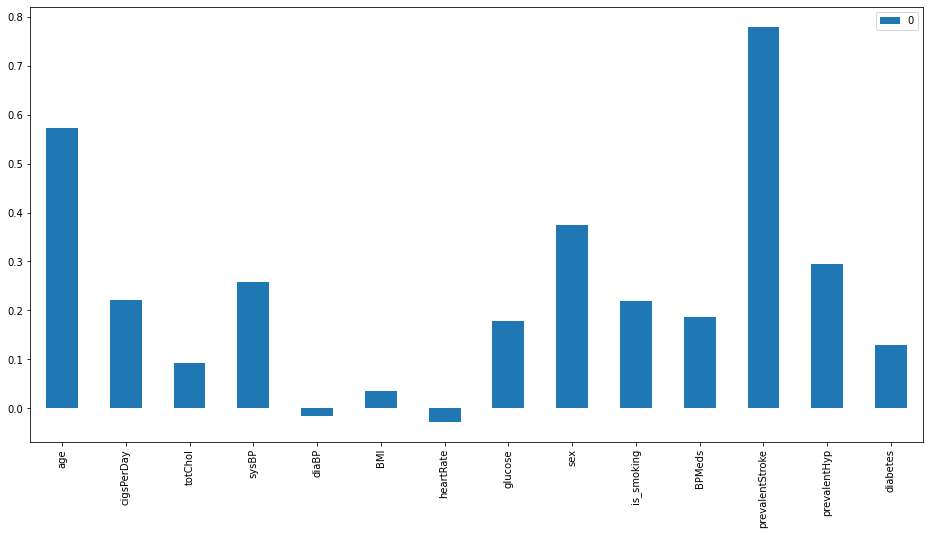

In [40]:
coeffs = pd.DataFrame(data = model_X.coef_, columns = data.columns)
coeffs.T.plot.bar(legend=True, figsize=(16,8));

* prevalancestroke (very detrimental effect), age , systolic bP, sex  has a very high and positive  effect  on the out come of prognosis.
* heartbeat and BPMeds has a negative effect on the outcome. 


<a name='8'></a>
## 8. Improve the Model

You can try to improve your model by including interaction terms. 
* An interaction term is the product of two variables. 
    

<a name='Ex-4'></a>
### Exercise 4

Write code below to add all interactions between every pair of variables to the training and test datasets. 

In [41]:
# UNQ_C4 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def add_interactions(X):
    """
    Add interaction terms between columns to dataframe.

    Args:
    X (dataframe): Original data

    Returns:
    X_int (dataframe): Original data with interaction terms appended. 
    """
    features = ['age','cigsPerDay','totChol','sysBP','diaBP','BMI', 'heartRate','glucose']
    m = len(features)
    X_int = X.copy(deep=True)


    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    # 'i' loops through all features in the original dataframe X
    for i in range(m):
        
        # get the name of feature 'i'
        feature_i_name = features[i]
        
        # get the data for feature 'i'
        feature_i_data =X_int[feature_i_name]
        
        # choose the index of column 'j' to be greater than column i
        for j in range(i+1, m):
            
            # get the name of feature 'j'
            feature_j_name = features[j]
            
            # get the data for feature j'
            feature_j_data = X_int[feature_j_name]
            
            # create the name of the interaction feature by combining both names
            # example: "apple" and "orange" are combined to be "apple_x_orange"
            feature_i_j_name =  f"{feature_i_name}_x_{feature_j_name}"
            print(feature_i_j_name)
            
            # Multiply the data for feature 'i' and feature 'j'
            # store the result as a column in dataframe X_int
            X_int[feature_i_j_name] = (feature_i_data) * (feature_j_data)
        
    ### END CODE HERE ###

    return X_int

#### Test Your Work

Run the cell below to check your implementation. 

In [ ]:
#preprocess_before_interactions = imputer(features , categorical)

In [ ]:
#X_train = preprocess_before_interactions.fit_transform(X_train_new)

In [ ]:
#X_train = pd.DataFrame(X_train , columns= features+categorical)

In [42]:
#X_train.head(1)
X_train = X_train_new.copy(deep=True)
X_test = X_test_new.copy(deep=True)

In [43]:
print("Original Data")
print(X_train_new.loc[:, :].head())
print("Data w/ Interactions")

print(add_interactions(X_train.loc[:,:].head()))

Original Data
        age  cigsPerDay   totChol  ...  prevalentStroke  prevalentHyp  diabetes
0 -0.182808   -0.765156  0.145239  ...              0.0           0.0       0.0
1 -0.182808    0.934489  0.674372  ...              0.0           0.0       0.0
2 -0.066429   -0.510209  0.189333  ...              0.0           1.0       0.0
3 -1.462980    1.784312  0.828703  ...              0.0           0.0       0.0
4  1.446501   -0.765156 -0.582320  ...              0.0           0.0       0.0

[5 rows x 14 columns]
Data w/ Interactions
age_x_cigsPerDay
age_x_totChol
age_x_sysBP
age_x_diaBP
age_x_BMI
age_x_heartRate
age_x_glucose
cigsPerDay_x_totChol
cigsPerDay_x_sysBP
cigsPerDay_x_diaBP
cigsPerDay_x_BMI
cigsPerDay_x_heartRate
cigsPerDay_x_glucose
totChol_x_sysBP
totChol_x_diaBP
totChol_x_BMI
totChol_x_heartRate
totChol_x_glucose
sysBP_x_diaBP
sysBP_x_BMI
sysBP_x_heartRate
sysBP_x_glucose
diaBP_x_BMI
diaBP_x_heartRate
diaBP_x_glucose
BMI_x_heartRate
BMI_x_glucose
heartRate_x_glucose
       

Once you have correctly implemented `add_interactions`, use it to make transformed version of `X_train` and `X_test`.

In [44]:
X_train_int = add_interactions(X_train_new)
X_test_int = add_interactions(X_test_new)

age_x_cigsPerDay
age_x_totChol
age_x_sysBP
age_x_diaBP
age_x_BMI
age_x_heartRate
age_x_glucose
cigsPerDay_x_totChol
cigsPerDay_x_sysBP
cigsPerDay_x_diaBP
cigsPerDay_x_BMI
cigsPerDay_x_heartRate
cigsPerDay_x_glucose
totChol_x_sysBP
totChol_x_diaBP
totChol_x_BMI
totChol_x_heartRate
totChol_x_glucose
sysBP_x_diaBP
sysBP_x_BMI
sysBP_x_heartRate
sysBP_x_glucose
diaBP_x_BMI
diaBP_x_heartRate
diaBP_x_glucose
BMI_x_heartRate
BMI_x_glucose
heartRate_x_glucose
age_x_cigsPerDay
age_x_totChol
age_x_sysBP
age_x_diaBP
age_x_BMI
age_x_heartRate
age_x_glucose
cigsPerDay_x_totChol
cigsPerDay_x_sysBP
cigsPerDay_x_diaBP
cigsPerDay_x_BMI
cigsPerDay_x_heartRate
cigsPerDay_x_glucose
totChol_x_sysBP
totChol_x_diaBP
totChol_x_BMI
totChol_x_heartRate
totChol_x_glucose
sysBP_x_diaBP
sysBP_x_BMI
sysBP_x_heartRate
sysBP_x_glucose
diaBP_x_BMI
diaBP_x_heartRate
diaBP_x_glucose
BMI_x_heartRate
BMI_x_glucose
heartRate_x_glucose


In [45]:
X_test_int.head(1)

,age,cigsPerDay,totChol,sysBP,diaBP,BMI,heartRate,glucose,sex,is_smoking,BPMeds,prevalentStroke,prevalentHyp,diabetes,age_x_cigsPerDay,age_x_totChol,age_x_sysBP,age_x_diaBP,age_x_BMI,age_x_heartRate,age_x_glucose,cigsPerDay_x_totChol,cigsPerDay_x_sysBP,cigsPerDay_x_diaBP,cigsPerDay_x_BMI,cigsPerDay_x_heartRate,cigsPerDay_x_glucose,totChol_x_sysBP,totChol_x_diaBP,totChol_x_BMI,totChol_x_heartRate,totChol_x_glucose,sysBP_x_diaBP,sysBP_x_BMI,sysBP_x_heartRate,sysBP_x_glucose,diaBP_x_BMI,diaBP_x_heartRate,diaBP_x_glucose,BMI_x_heartRate,BMI_x_glucose,heartRate_x_glucose
0,0.765401,1.705693,1.203321,-0.4256,-1.039622,-1.671768,-0.30458,0.685601,0.0,1.0,0.0,0.0,0.0,0.0,1.305539,0.921023,-0.325754,-0.795728,-1.279573,-0.233126,0.52476,2.052497,-0.725943,-1.773277,-2.851523,-0.51952,1.169425,-0.512133,-1.251,-2.011674,-0.366508,0.824999,0.442463,0.711504,0.129629,-0.291792,1.738007,0.316648,-0.712766,0.509187,-1.146166,-0.20882


In [46]:
X_train_int.head(1)

,age,cigsPerDay,totChol,sysBP,diaBP,BMI,heartRate,glucose,sex,is_smoking,BPMeds,prevalentStroke,prevalentHyp,diabetes,age_x_cigsPerDay,age_x_totChol,age_x_sysBP,age_x_diaBP,age_x_BMI,age_x_heartRate,age_x_glucose,cigsPerDay_x_totChol,cigsPerDay_x_sysBP,cigsPerDay_x_diaBP,cigsPerDay_x_BMI,cigsPerDay_x_heartRate,cigsPerDay_x_glucose,totChol_x_sysBP,totChol_x_diaBP,totChol_x_BMI,totChol_x_heartRate,totChol_x_glucose,sysBP_x_diaBP,sysBP_x_BMI,sysBP_x_heartRate,sysBP_x_glucose,diaBP_x_BMI,diaBP_x_heartRate,diaBP_x_glucose,BMI_x_heartRate,BMI_x_glucose,heartRate_x_glucose
0,-0.182808,-0.765156,0.145239,-0.705568,-0.107908,0.777216,-0.761997,-0.180378,0.0,0.0,0.0,0.0,0.0,0.0,0.139877,-0.026551,0.128984,0.019726,-0.142081,0.139299,0.032975,-0.11113,0.53987,0.082567,-0.594692,0.583047,0.138017,-0.102476,-0.015672,0.112882,-0.110672,-0.026198,0.076137,-0.548379,0.537641,0.127269,-0.083868,0.082226,0.019464,-0.592237,-0.140193,0.137448


<a name='9'></a>
## 9. Evaluate the Improved Model

Now we can train the new and improved version of the model.

In [47]:
model_X_int, data_int = lr_model(X_train_int, y_train, preprocessor, impute=False)

[LibLinear]

Let's evaluate our new model on the test set.

In [48]:
scores_X = model_X.predict_proba(X_test)[:, 1]
c_index_X_int_test = cindex(y_test.values, scores_X)

No of permissable : 58752
No of concordant : 42431


In [49]:
scores_X_int = model_X_int.predict_proba(X_test_int)[:, 1]
c_index_X_int_test = cindex(y_test.values, scores_X_int)

print(f"c-index on test set without interactions is {c_index_X_test:.4f}")
print(f"c-index on test set with interactions is {c_index_X_int_test:.4f}")

No of permissable : 58752
No of concordant : 41679
c-index on test set without interactions is 0.7222
c-index on test set with interactions is 0.7094


In [50]:
data_int.head(1)

,age,cigsPerDay,totChol,sysBP,diaBP,BMI,heartRate,glucose,sex,is_smoking,BPMeds,prevalentStroke,prevalentHyp,diabetes,age_x_cigsPerDay,age_x_totChol,age_x_sysBP,age_x_diaBP,age_x_BMI,age_x_heartRate,age_x_glucose,cigsPerDay_x_totChol,cigsPerDay_x_sysBP,cigsPerDay_x_diaBP,cigsPerDay_x_BMI,cigsPerDay_x_heartRate,cigsPerDay_x_glucose,totChol_x_sysBP,totChol_x_diaBP,totChol_x_BMI,totChol_x_heartRate,totChol_x_glucose,sysBP_x_diaBP,sysBP_x_BMI,sysBP_x_heartRate,sysBP_x_glucose,diaBP_x_BMI,diaBP_x_heartRate,diaBP_x_glucose,BMI_x_heartRate,BMI_x_glucose,heartRate_x_glucose
0,-0.182808,-0.765156,0.145239,-0.705568,-0.107908,0.777216,-0.761997,-0.180378,0.0,0.0,0.0,0.0,0.0,0.0,0.139877,-0.026551,0.128984,0.019726,-0.142081,0.139299,0.032975,-0.11113,0.53987,0.082567,-0.594692,0.583047,0.138017,-0.102476,-0.015672,0.112882,-0.110672,-0.026198,0.076137,-0.548379,0.537641,0.127269,-0.083868,0.082226,0.019464,-0.592237,-0.140193,0.137448


In [53]:
print(accuracy_score(y_test , np.rint(scores_X_int)))

0.6622418879056047


You should see that the model with interaction terms performs a bit better than the model without interactions.

Now let's take another look at the model coefficients to try and see which variables made a difference. Plot the coefficients and report which features seem to be the most important.

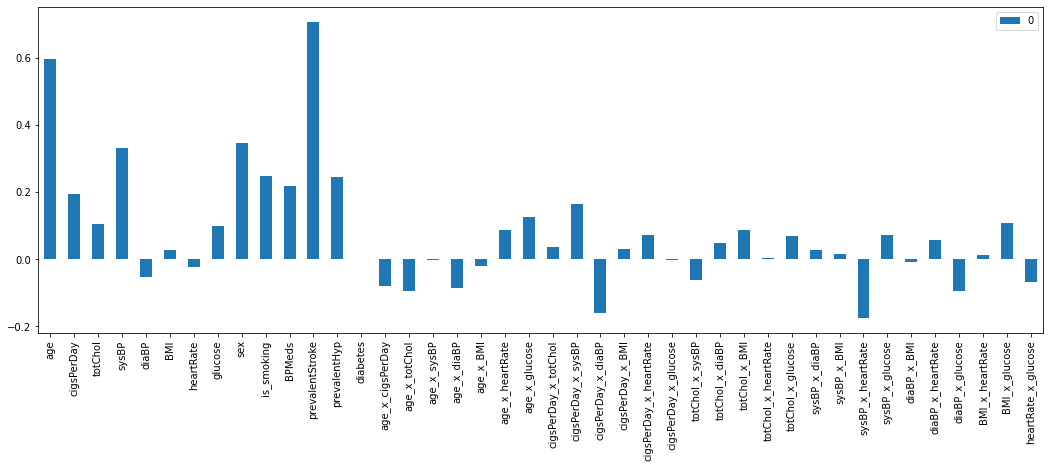

In [54]:
int_coeffs = pd.DataFrame(data = model_X_int.coef_, columns = X_train_int.columns)
#plt.figure(figsize=(16,7))
int_coeffs.T.plot.bar(figsize=(18,6));

In [55]:
int_coeffs

,age,cigsPerDay,totChol,sysBP,diaBP,BMI,heartRate,glucose,sex,is_smoking,BPMeds,prevalentStroke,prevalentHyp,diabetes,age_x_cigsPerDay,age_x_totChol,age_x_sysBP,age_x_diaBP,age_x_BMI,age_x_heartRate,age_x_glucose,cigsPerDay_x_totChol,cigsPerDay_x_sysBP,cigsPerDay_x_diaBP,cigsPerDay_x_BMI,cigsPerDay_x_heartRate,cigsPerDay_x_glucose,totChol_x_sysBP,totChol_x_diaBP,totChol_x_BMI,totChol_x_heartRate,totChol_x_glucose,sysBP_x_diaBP,sysBP_x_BMI,sysBP_x_heartRate,sysBP_x_glucose,diaBP_x_BMI,diaBP_x_heartRate,diaBP_x_glucose,BMI_x_heartRate,BMI_x_glucose,heartRate_x_glucose
0,0.597507,0.194257,0.105457,0.330491,-0.052206,0.028428,-0.023696,0.098316,0.34531,0.247682,0.219202,0.708423,0.244073,0.0,-0.080736,-0.096354,-0.001649,-0.084923,-0.021792,0.086834,0.126968,0.035782,0.164884,-0.15945,0.03027,0.072121,-0.003292,-0.062235,0.04909,0.086214,0.00393,0.069776,0.027153,0.015085,-0.176083,0.072395,-0.008411,0.057669,-0.094729,0.012209,0.108741,-0.068307


In [56]:
index = index = 10
case = X_train_int.iloc[index, :]
print(case)

age                      -0.881083
cigsPerDay                1.359401
totChol                   1.071222
sysBP                     0.045672
diaBP                    -0.234870
BMI                       0.110236
heartRate                -0.086356
glucose                  -0.731819
sex                       0.000000
is_smoking                1.000000
BPMeds                    0.000000
prevalentStroke           0.000000
prevalentHyp              0.000000
diabetes                  0.000000
age_x_cigsPerDay         -1.197746
age_x_totChol            -0.943836
age_x_sysBP              -0.040241
age_x_diaBP               0.206940
age_x_BMI                -0.097127
age_x_heartRate           0.076086
age_x_glucose             0.644794
cigsPerDay_x_totChol      1.456220
cigsPerDay_x_sysBP        0.062087
cigsPerDay_x_diaBP       -0.319282
cigsPerDay_x_BMI          0.149855
cigsPerDay_x_heartRate   -0.117392
cigsPerDay_x_glucose     -0.994835
totChol_x_sysBP           0.048925
totChol_x_diaBP     

We can see that they have above average Age and Cholesterol. We can now see what our original model would have output by zero-ing out the value for Cholesterol and Age.

In [ ]:
new_case = case.copy(deep=True)
new_case.loc["BMI"] = 0
new_case

age                      -0.165730
cigsPerDay                0.075576
totChol                   0.677760
sysBP                    -0.669144
diaBP                    -0.237867
BMI                       0.000000
heartRate                -0.315395
glucose                  -0.651025
sex                       0.000000
is_smoking                1.000000
BPMeds                    0.000000
prevalentStroke           0.000000
prevalentHyp              1.000000
diabetes                  0.000000
age_x_cigsPerDay         -0.012525
age_x_totChol            -0.112325
age_x_sysBP               0.110897
age_x_diaBP               0.039422
age_x_BMI                -0.417063
age_x_heartRate           0.052270
age_x_glucose             0.107894
cigsPerDay_x_totChol      0.051222
cigsPerDay_x_sysBP       -0.050571
cigsPerDay_x_diaBP       -0.017977
cigsPerDay_x_BMI          0.190187
cigsPerDay_x_heartRate   -0.023836
cigsPerDay_x_glucose     -0.049202
totChol_x_sysBP          -0.453519
totChol_x_diaBP     

In [ ]:
print(f"Output with interaction: \t{model_X_int.predict_proba([case.values])[:, 1][0]:.4f}")
print(f"Output without interaction: \t{model_X_int.predict_proba([new_case.values])[:, 1][0]:.4f}")

Output with interaction: 	0.0609
Output without interaction: 	0.0774
